In [1]:
import pypsa
import pandas as pd
import numpy as np
import os
import pypsatopo
from xlsxwriter import Workbook

In [4]:
solver = "cbc"

In [6]:
# Create empty PyPSA network
n = pypsa.Network()

In [68]:
# Set snapshots to the year 2023 and at hourly resolution
snapshots = pd.date_range("01-01-2019", "01-01-2020", freq="h", inclusive="left")
n.set_snapshots(snapshots)

In [69]:
# To calculate annualized capital expenditure
def calculate_annualised_capex(capex: float, interest: float, lifetime: int):
    crf = (
        interest * (1 + interest) ** lifetime / ((1 + interest) ** lifetime - 1)
    )  # Capital recovery factor
    return capex * crf

In [70]:
#Removal of certain components

#n.remove(class_name="Link", name="electricity_flow")
#n.remove(class_name="Bus", name="electricity_storage")

<Axes: xlabel='snapshot'>

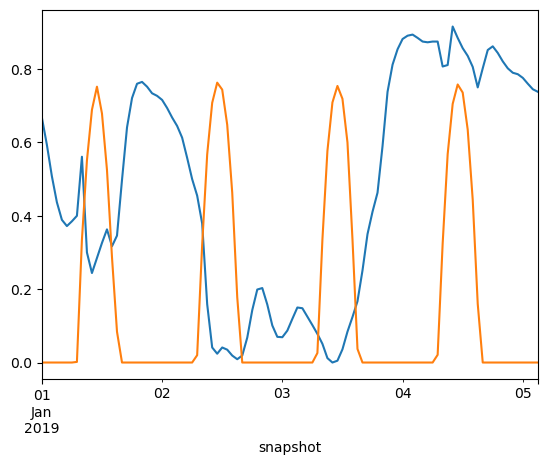

In [512]:
# Import an example of wind daily pattern
wind_pattern = pd.read_csv("/data/JiLi_BC_wind_GW.csv")["daily pattern"]
# annual time-series availability of onshore wind (just a simplified example)
wind_profile = pd.Series(list(wind_pattern), index=n.snapshots)

# Import an example of solar daily pattern
solar_pattern = pd.read_csv("/data/JiLi_BC_PV.csv")["daily pattern"]
# annual time-series availability of solar (just a simplified example)
solar_profile = pd.Series(list(solar_pattern), index=n.snapshots)

# Import an example of wind daily pattern
#load_pattern = pd.read_csv("/data/weather data/example_industrial_h2_demand_daily_pattern.csv")["daily pattern"]
# annual time-series availability of onshore wind (just a simplified example)
#load_profile = pd.Series(list(load_pattern)*365, index=n.snapshots)

# Print first few values to verify
wind_profile.head(100).plot()
solar_profile.head(100).plot()

In [513]:
# create the buses needed for the ammonia system
n.add(class_name="Bus", name="electricity", carrier="electricity", overwrite=True)

#n.add(class_name="Bus", name="electricity_storage", carrier="electricity", overwrite=True)

# hydrogen buses
n.add(class_name="Bus", name="hydrogen", carrier="hydrogen", overwrite=True)
n.add(class_name="Bus", name="hydrogen_storage", carrier="hydrogen", overwrite=True)
# ammonia buses
n.add(class_name="Bus", name="ammonia", carrier="ammonia", overwrite=True)
n.add(class_name="Bus", name="ammonia_storage", carrier="ammonia", overwrite=True)

n.buses

,v_nom,type,x,y,carrier,unit,v_mag_pu_set,v_mag_pu_min,v_mag_pu_max,control,generator,sub_network
Bus,,,,,,,,,,,,
electricity,1.0,,0.0,0.0,electricity,,1.0,0.0,inf,PQ,,
hydrogen,1.0,,0.0,0.0,hydrogen,,1.0,0.0,inf,PQ,,
hydrogen_storage,1.0,,0.0,0.0,hydrogen,,1.0,0.0,inf,PQ,,
ammonia,1.0,,0.0,0.0,ammonia,,1.0,0.0,inf,PQ,,
ammonia_storage,1.0,,0.0,0.0,ammonia,,1.0,0.0,inf,PQ,,


In [514]:
#create the end demand load for ammonia

#n.remove(class_name="Load", name="hydrogen_load")
n.add(class_name="Load", name="ammonia_load", bus="ammonia", p_set=100, overwrite=True) 
#n.add(class_name="Load", name="hydrogen_load", bus="hydrogen", p_set=100, carrier="hydrogen", type="hydrogen_load", overwrite=True)
# or p_set=load_profile
n.loads


,bus,carrier,type,p_set,q_set,sign,active
Load,,,,,,,
ammonia_load,ammonia,,,100.0,0.0,-1.0,True


In [516]:
#exchange rates
eur_to_usd = 1.1
usd_to_cny = 7.0774

# interest rate / discount rate
interest = 0.0563 # according to BOA PTX; original value: 0.05

In [518]:
# create the generators for wind, based on techno-economic parameters
# Onshore Wind's techno-economic parameters are given as:
lifetime = 20
interest = 0.0563 # according to BOA PTX; original value: 0.05
CAPEX = 4500 * 1000 / usd_to_cny # $/MW
FOM = 2 #% of CAPEX
VOM = 0 # $/MWh variable
efficiency = 1

annualized_capex = calculate_annualised_capex(CAPEX, interest, lifetime)

n.add(
    class_name="Generator", 
    name="onshore_wind",
    bus="electricity",
    carrier="wind",
    p_nom_extendable=True,
    p_nom_min=100, # MW
    #p_nom_max=500, # MW
    capital_cost=annualized_capex + FOM/100 * annualized_capex, #$/MW
    marginal_cost=VOM, #$/MWh
    efficiency=efficiency,
    lifetime=lifetime,
    p_max_pu=wind_profile, 
    overwrite=True
)

Index(['onshore_wind'], dtype='object', name='Generator')

In [520]:
# create the generator for solar, based on techno-economic parameters
# Solar's techno-economic parameters are given as:
lifetime = 25
interest = 0.0563 # according to BOA PTX; original value: 0.05
CAPEX = 3940 * 1000 / usd_to_cny # $/MW
FOM = 1 #% of CAPEX
VOM = 0 # $/MWh variable
efficiency = 1

annualized_capex = calculate_annualised_capex(CAPEX, interest, lifetime)

n.add(
    class_name="Generator", 
    name="solar",
    bus="electricity",
    carrier="solar",
    p_nom_extendable=True,
    p_nom_min=50,
    #p_nom_max=500, # MW
    capital_cost=annualized_capex + FOM/100 * annualized_capex, #$/MW
    marginal_cost=VOM, #$/MWh
    efficiency=efficiency,
    lifetime=lifetime,
    p_max_pu=solar_profile, 
    overwrite=True
)

Index(['solar'], dtype='object', name='Generator')

In [523]:
#create the generator for hybrid supply

#n.add(class_name="Generator", name="hybrid_wind_solar", bus="electricity", carrier="wind", overwrite=True)

n.generators

,bus,control,type,p_nom,p_nom_mod,p_nom_extendable,p_nom_min,p_nom_max,p_min_pu,p_max_pu,...,min_up_time,min_down_time,up_time_before,down_time_before,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down,weight,p_nom_opt
Generator,,,,,,,,,,,,,,,,,,,,,
onshore_wind,electricity,PQ,,0.0,0.0,True,100.0,inf,0.0,1.0,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0
solar,electricity,PQ,,0.0,0.0,True,50.0,inf,0.0,1.0,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0


In [525]:
# create hydrogen storage tank

#Techno-economic data for hydrogen storage tank
lifetime = 20
interest = 0.0563 # according to BOA PTX; original value: 0.05
CAPEX = 59.7 * 1000 # $/MWh (based on H2 compressed storage tank DTU data); original value: 4779.9527
FOM = 0.43 #%/year; unchanged

annualized_capex = calculate_annualised_capex(CAPEX, interest, lifetime)

n.add(
      class_name="Store",
      name="hydrogen_tank",
      type="hydrogen_tank",
      bus="hydrogen_storage",
      carrier="hydrogen",
      capital_cost=annualized_capex + FOM/100 * annualized_capex,
      e_nom_extendable=True,
      e_cyclic=False,
      marginal_cost=1,#$/MWh 
      overwrite=True
)


Index(['hydrogen_tank'], dtype='object')

In [526]:
# create ammonia storage tank
# Ammonia tank's techno-economic parameters are given as:
eur_to_usd = 1.1
lifetime = 20
interest = 0.0563

CAPEX = 166.8201 * eur_to_usd # $/MWh
FOM = 4.0 # %/year

annualized_capex = calculate_annualised_capex(CAPEX, interest, lifetime)


n.add(
    class_name="Store", 
    name="ammonia_tank",
    type="ammonia_tank",
    bus="ammonia_storage", 
    carrier="ammonia",
    e_nom_extendable=True,
#    e_nom_max=5000,
    e_cyclic=False,
#    e_initial=0,
    capital_cost= annualized_capex * FOM/100 * annualized_capex,
    marginal_cost=1, 
    overwrite=True
)

n.stores

,bus,type,carrier,e_nom,e_nom_mod,e_nom_extendable,e_nom_min,e_nom_max,e_min_pu,e_max_pu,...,sign,marginal_cost,marginal_cost_quadratic,marginal_cost_storage,capital_cost,standing_loss,active,build_year,lifetime,e_nom_opt
Store,,,,,,,,,,,,,,,,,,,,,
hydrogen_tank,hydrogen_storage,hydrogen_tank,hydrogen,0.0,0.0,True,0.0,inf,0.0,1.0,...,1.0,1.0,0.0,0.0,5071.388888,0.0,True,0,inf,0.0
ammonia_tank,ammonia_storage,ammonia_tank,ammonia,0.0,0.0,True,0.0,inf,0.0,1.0,...,1.0,1.0,0.0,0.0,9.636523,0.0,True,0,inf,0.0


In [529]:
# Techno-economic parameters of a lithium ion battery storage:

lifetime = 12.5  # years (average: 10-15); https://greencubes.com/in-the-news/why-lithium-is-taking-over-stationary-energy-storage/
interest = 0.0563  # unit: -
CAPEX = 160 * 1000  # $/MW; original: 600 # 80USD / kWh storage (Nov 2024), assuming 2Ah storages. Source: https://www.energy-storage.news/mind-blowing-bids-power-chinas-16gwh-bess-tender-state-owned-firms-market-share/
FOM = 1.5  # $/MW per year (between 1% and 2% of the CAPEX)
VOM = 0  # $/MWh
fuel_cost = 0  # $/MWh_th per unit water consumed
efficiency_store = 0.965  # assuming similar storing and discharging efficiencies #https://blog.discoverbattery.com/understanding-charging
efficiency_dispatch = 0.965  # assuming similar storing and discharging efficiencies

annualized_capex = calculate_annualised_capex(CAPEX, interest, lifetime)

n.add(
    class_name="StorageUnit",
    name="battery",
    bus="electricity",
    marginal_cost= VOM + fuel_cost,
    capital_cost=annualized_capex + FOM/100 * annualized_capex,
    p_nom_extendable=True,
    efficiency_store=efficiency_store,
    efficiency_dispatch=efficiency_dispatch,
    p_max_pu=1,  # Discharging availability
    p_min_pu=-1,  # Charging availability
    max_hours=2,  # energy-to-power ratio assumption is 2Ah
#    state_of_charge_initial=100,
    overwrite=True
)


#LCOH MAP is behaving in the same way because hydrogen and ammonia storage are cheaper
# set p_min if you want to really use batteries.

Index(['battery'], dtype='object')

In [531]:
#create the links for electrolysers, ammonia synthesis, electricity flow and hydrogen flow
"""
n.add(
    class_name="Link", 
    name="electricity_flow",
    bus0="electricity",
    bus1="electricity_storage",
    p_nom_extendable=True, # allow flexible capacity expansion
    marginal_cost=1, #$/MWh 
    efficiency=1,
    p_min_pu=-1, #bi-directional flow
    overwrite=True
)
"""
n.add(
    class_name="Link", 
    name="hydrogen_flow",
    bus0="hydrogen",
    bus1="hydrogen_storage",
    p_nom_extendable=True, # allow flexible capacity expansion
    marginal_cost=1, #$/MWh 
    efficiency=1,
    p_min_pu=-1, #bi-directional flow
    overwrite=True
)

n.add(
    class_name="Link", 
    name="ammonia_flow",
    bus0="ammonia",
    bus1="ammonia_storage",
    p_nom_extendable=True, # allow flexible capacity expansion
    marginal_cost=1, #$/MWh 
    efficiency=1,
    p_min_pu=-1, #bi-directional flow
    overwrite=True
)

n.links

,bus0,bus1,type,carrier,efficiency,active,build_year,lifetime,p_nom,p_nom_mod,...,min_down_time,up_time_before,down_time_before,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down,p_nom_opt,bus2,efficiency2
Link,,,,,,,,,,,,,,,,,,,,,
electrolyser,electricity,hydrogen,,Electrolyser,0.590000,True,0,20.0,0.0,0.0,...,0,1,0,0.30,0.30,0.150,1.0,318.013850,,1.000000
haber_bosch,electricity,ammonia,,Haber-Bosch,7.042254,True,0,20.0,0.0,0.0,...,0,1,0,0.13,0.13,0.015,1.0,14.598739,hydrogen,-8.588099
hydrogen_flow,hydrogen,hydrogen_storage,,,1.000000,True,0,inf,0.0,0.0,...,0,1,0,NaN,NaN,1.000,1.0,0.000000,,1.000000
ammonia_flow,ammonia,ammonia_storage,,,1.000000,True,0,inf,0.0,0.0,...,0,1,0,NaN,NaN,1.000,1.0,0.000000,,1.000000


In [533]:
#create the link for the electrolyser

# Electrolyser's techno-economic parameters are given as:
lifetime = 20
interest = 0.0563
#water_cost = 1.8 # EUR/m3_H2O --> this includes the water treatment costs applied to the seawater
#water_demand_ratio= 21 # kgH2O/kgH2 --> how much water is needed to produce 1 kg of hydrogen?

CAPEX = 600.34 *1000 # $/MW
FOM = 2 # %/year or CAPEX
VOM = 0 # $/MWh variable
efficiency = 0.59
ramp_limit_up= 0.3 #%/hour Source #4: Bodke et al (2021)
ramp_limit_down = 0.3 #%/hour Source #4: Bodke et al (2021)
ramp_limit_start_up = 0.15 #%/hour Source #4: Bodke et al (2021)
min_up_time = 2 #hours Source #4: Bodke et al (2021)

"""
# Calculate marginal cost for water consumption
# marginal cost [USD/MWh] = 
# water_cost [EUR/m3_H2O] * eur_to_usd [USD/EUR] / 1000 [kgH2O/m3_H2O] * water_demand_ratio [kgH2O/kgH2] / (33.33/1000 [MWh/kgH2])
water_cost = ((water_cost * eur_to_usd / 1000) * water_demand_ratio) / (33.33 / 1000) # 1 kgH2 = 33.33 kWh = 0.03333 MWh

# Add a compressor to pressurize hydrogen produced by the electrolyser and feed it to the hydrogen storage
# 1. Calculate the specific electricity consumption for compressor in kWh_el/kWh_H2. Assumption: 0.6 [kWh_el/kgH2]
# 2. Calculate the specific energy consumption for the electrolyser in kWh_el/kWh_H2. This corresponds to the reciprocal of the electrolyser's efficiency.
# 3. The sum of the two specific energy consumptions represents the total specific energy consumption for the electrolyser including compressor.
# 4. Calculate the new efficiency of the electrolyser which is the reciprocal of the total specific energy consumption.
specific_consumption_compressor = 0.6 / 33.33  # 0.6 [kWh_el/kgH2] / 33.33 [kWh_H2/kgH2] --> kWh_el/kWh_H2
specific_consumption_electrolyser = 1 / efficiency # unit: kWh_el/kWh_H2
new_efficiency = 1 / (specific_consumption_compressor + specific_consumption_electrolyser)

# Compressor's techno-economic parameters are given as:
lifetime_com = 25
CAPEX_COM = 1720 * eur_to_usd # $/MW
FOM_COM = 34 * eur_to_usd  # $/MW fixed
VOM_COM = 0 # $/MWh variable
"""
annualized_capex = calculate_annualised_capex(CAPEX, interest, lifetime)
#annualized_capex_com = calculate_annualised_capex(CAPEX_COM, interest, lifetime_com)

n.add(
    class_name="Link",
    name="electrolyser",
    carrier="Electrolyser",
    bus0="electricity",
    bus1="hydrogen",
    p_nom_extendable=True,
    p_nom_min=20,
    capital_cost=annualized_capex + FOM/100 * annualized_capex, #$/MW
    marginal_cost=VOM, #$/MWh
    efficiency=efficiency,
    lifetime=lifetime,
    ramp_limit_up=ramp_limit_up,
    ramp_limit_down=ramp_limit_down,
    ramp_limit_start_up=ramp_limit_start_up,
    min_up_time=min_up_time,
    overwrite=True
)

"""
p_min_pu=0.6 
p_max_pu=1
"""

'\np_min_pu=0.6 \np_max_pu=1\n'

In [535]:
#create the link for the Haber-Bosch's ammonia synthesis (UPDATE)

# Haber-Bosch's techno-economic parameters are given as:

lifetime = 20 # original value: 30
interest = 0.0563 # according to BOA PTX; original value: 0.05 

CAPEX = 718.9 * 1000 # $/MW; original value: 1622.5424
FOM = 2.0 # %/year 
VOM = 10.851  # $/MWh_NH3 ($ / t nitrogen cost); original value: 0.0225 * eur_to_usd
electricity_input_hb = 0.142 #MWh_el/MWh_NH3 (0.142); original value: 0.2473
hydrogen_input = 1.21951 #MWh_H2/MWh_NH3 (includes efficiency losses); original value: 1.1484
ramp_limit_up= 0.13 #in %; from Darlene
ramp_limit_down = 0.13  #in %; from Darlene
ramp_limit_start_up = 0.015 #MW/hour Source #4: Bodke et al (2021)
min_up_time = 2 #hours Source #4: Bodke et al (2021)

annualized_capex = calculate_annualised_capex(CAPEX, interest, lifetime)


n.add(
    class_name = "Link",
    name = "haber_bosch",
    carrier="Haber-Bosch",
    bus0="electricity",
    bus1="ammonia",
    bus2="hydrogen",
    p_nom_extendable=True,
    p_min_pu=0.6,
    p_max_pu=1,
    efficiency=1 / electricity_input_hb,
    efficiency2=-hydrogen_input / electricity_input_hb,
    capital_cost=(annualized_capex + FOM/100 * annualized_capex) / electricity_input_hb,
    marginal_cost=VOM / electricity_input_hb,
    lifetime=lifetime,
    ramp_limit_up=ramp_limit_up,
    ramp_limit_down=ramp_limit_down,
    ramp_limit_start_up=ramp_limit_start_up,
    min_up_time=min_up_time,
    overwrite=True
)

"""
p_min_pu=0.6 
p_max_pu=1
"""
#maybe limit ammonia tank? 

'\np_min_pu=0.6 \np_max_pu=1\n'

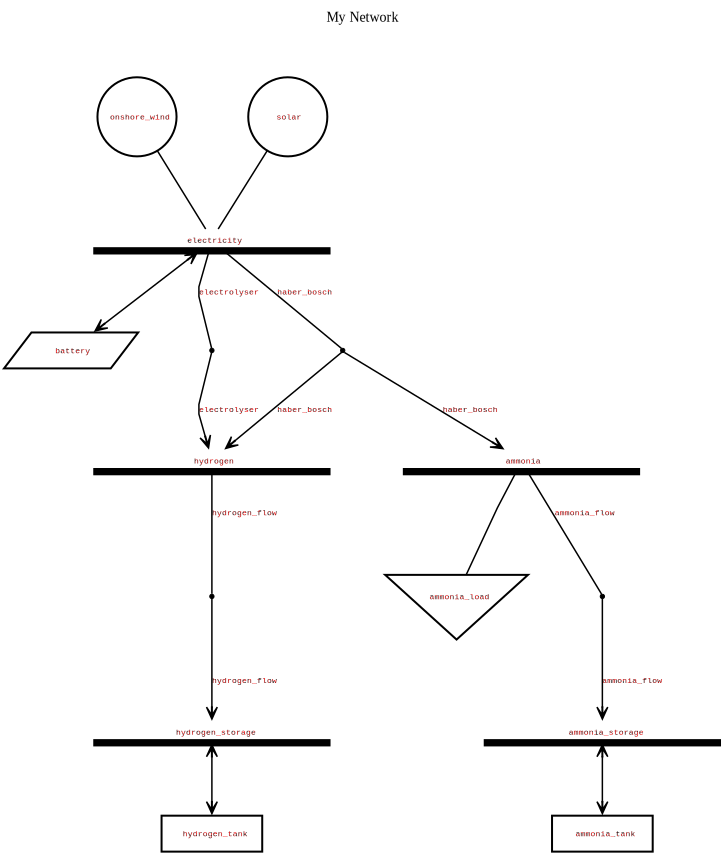

0

In [537]:
pypsatopo.generate(n)

In [539]:
# Solve network using cbc solver
n.optimize(pyomo=False, solver_name=solver)

Index(['hydrogen_flow', 'ammonia_flow', 'electrolyser', 'haber_bosch'], dtype='object', name='Link')
Index(['hydrogen_tank', 'ammonia_tank'], dtype='object', name='Store')
Index(['electricity', 'hydrogen', 'hydrogen_storage', 'ammonia',
       'ammonia_storage'],
      dtype='object', name='Bus')
Index(['onshore_wind', 'solar'], dtype='object', name='Generator')
Index(['hydrogen_flow', 'ammonia_flow', 'electrolyser', 'haber_bosch'], dtype='object', name='Link')
Index(['hydrogen_tank', 'ammonia_tank'], dtype='object', name='Store')
Index(['electricity', 'hydrogen', 'hydrogen_storage', 'ammonia',
       'ammonia_storage'],
      dtype='object', name='Bus')
Index(['onshore_wind', 'solar'], dtype='object', name='Generator')
INFO:linopy.model: Solve problem using Cbc solver
INFO:linopy.model:Solver options:
 - pyomo: False
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|████████████| 11/11 [00:00<00:00, 28.55it/s]
INFO:linopy.io: Writing time: 2.81s
INFO:linopy.solvers

('ok', 'optimal')

In [540]:
n.stores_t.p

Store,hydrogen_tank,ammonia_tank
snapshot,,
2019-01-01 00:00:00,-5.346739e+01,-2.796457e+00
2019-01-01 01:00:00,-3.270297e+01,-2.796457e+00
2019-01-01 02:00:00,-1.302234e+01,6.187446e-01
2019-01-01 03:00:00,1.135128e+01,-2.796457e+00
2019-01-01 04:00:00,2.482009e+01,-2.796457e+00
...,...,...
2019-12-31 19:00:00,1.333834e+01,1.421086e-14
2019-12-31 20:00:00,1.421086e-14,-2.796457e+00
2019-12-31 21:00:00,1.421086e-14,2.796457e+00


In [541]:
pd.concat([n.stores_t.e,n.stores_t.p],axis=1).head()


Store,hydrogen_tank,ammonia_tank,hydrogen_tank,ammonia_tank
snapshot,,,,
2019-01-01 00:00:00,53.467386,2.796457,-53.467386,-2.796457
2019-01-01 01:00:00,86.170353,5.592914,-32.702966,-2.796457
2019-01-01 02:00:00,99.192694,4.974169,-13.022341,0.618745
2019-01-01 03:00:00,87.841418,7.770626,11.351276,-2.796457
2019-01-01 04:00:00,63.021329,10.567083,24.820089,-2.796457


In [542]:
n.generators.p_nom_opt

Generator
onshore_wind    475.59368
solar           490.15047
Name: p_nom_opt, dtype: float64

<Axes: xlabel='snapshot'>

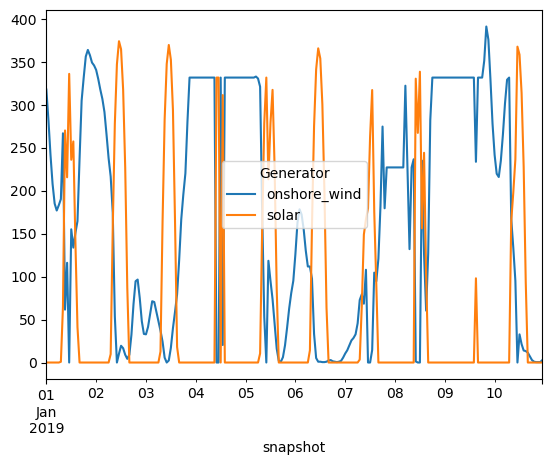

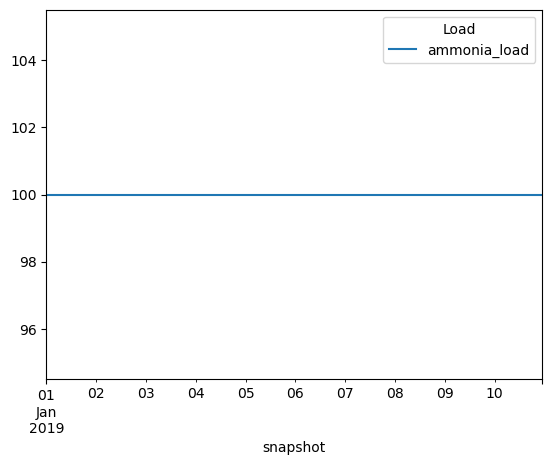

In [544]:
# Inspect the interaction of different power plants to supply loads
n.generators_t.p[:24*10].plot()

# Inspect the interaction of ammonia load to supply loads
n.loads_t.p[:24*10].plot()

<Axes: xlabel='snapshot'>

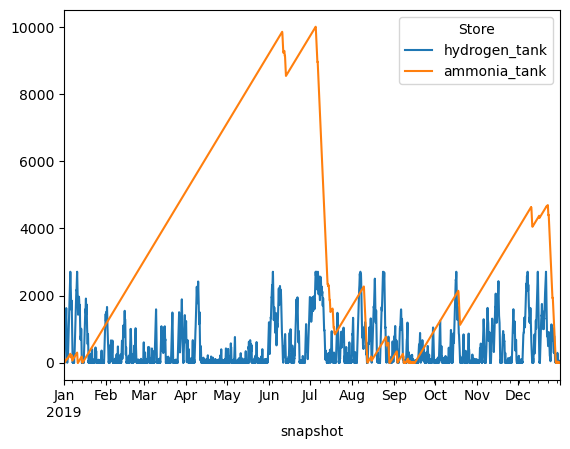

In [545]:
# Inspect the change of energy capacity [MWh] in hydrogen_tank store to supply loads
n.stores_t.e[:24*365].plot()

<Axes: xlabel='snapshot'>

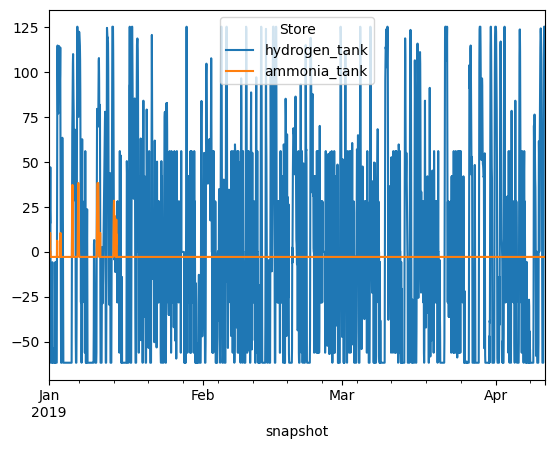

In [546]:
# Inspect the change of power [MW] in hydrogen_tank store to supply loads
n.stores_t.p[:24*100].plot()

<Axes: xlabel='snapshot'>

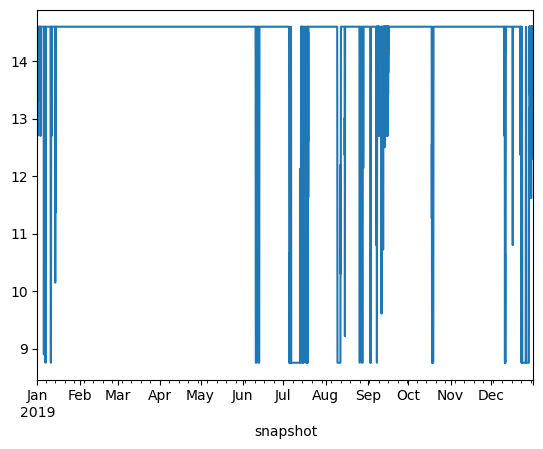

In [547]:
# Inspect the electrolysis input power
#n.links_t.p0["electrolyser"][:24*10].plot()

# Inspect the Haber Bosch input power
n.links_t.p0["haber_bosch"][:24*365].plot()

<Axes: xlabel='snapshot'>

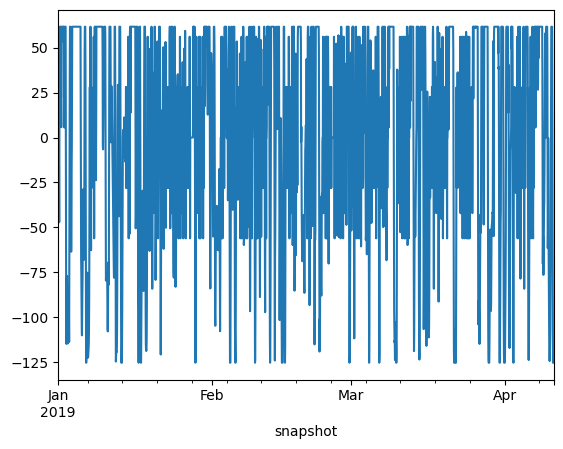

In [548]:
# Inspect the charging flow
n.links_t.p0["hydrogen_flow"][:24*100].plot()

<Axes: xlabel='snapshot'>

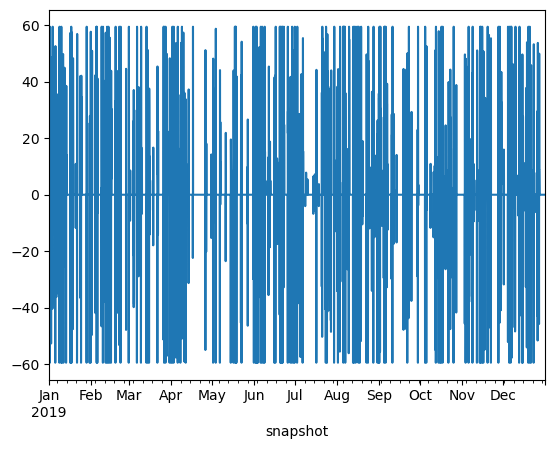

In [549]:
# Inspect the charging flow
n.storage_units_t.p["battery"][:24*365].plot()

<Axes: xlabel='snapshot'>

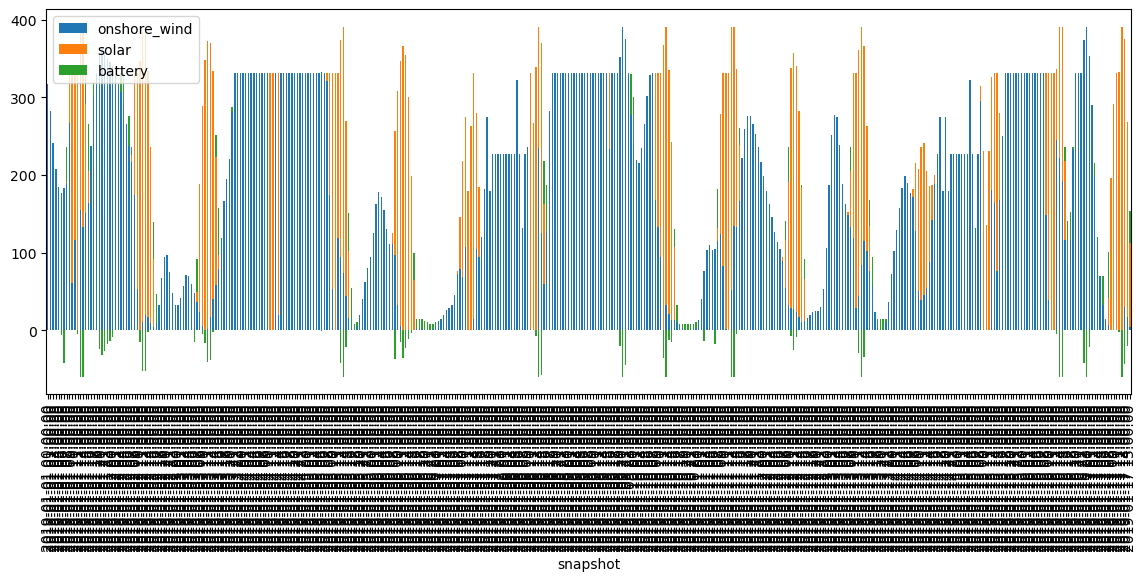

In [550]:
# Inspect storage interaction with other powerplants to supply loads
load = n.loads_t.p
pow_gen = n.generators_t.p
storage = n.storage_units_t.p
result = pd.concat([pow_gen, storage, load], axis=1)

plot = result.loc[
    :, ~result.columns.isin(["ammonia_load"])
]  # drop load and nuclear columns
plot.iloc[:400, :].plot(kind="bar", stacked=True, figsize=(14, 5))

In [551]:
n.statistics()

Optimal Capacity  Installed Capacity        Supply  \
Generator   solar                490.15047                 0.0  5.586302e+05   
            wind                 475.59368                 0.0  1.378070e+06   
Link        Electrolyser         317.04583                 0.0  1.068291e+06   
            Haber-Bosch           14.59710                 0.0  8.760000e+05   
            ammonia               38.32213                 0.0  4.455969e+04   
            hydrogen             125.36131                 0.0  3.609369e+05   
Load        -                      0.00000                 0.0  0.000000e+00   
StorageUnit -                     59.41811                 0.0  2.228962e+04   
Store       ammonia            10006.06400                 0.0  2.227984e+04   
            hydrogen            2709.15310                 0.0  1.804685e+05   

                            Withdrawal  Energy Balance  Transmission  \
Generator   solar         0.000000e+00    5.586302e+05       0.00000   
            wind          0.000000e+00    1.378070e+06       0.00000   
Link        Electrolyser  1.810662e+06   -7.423715e+05       0.00000   
            Haber-Bosch   1.192683e+06   -3.166828e+05       0.00000   
            ammonia       4.455969e+04    0.000000e+00       0.00005   
            hydrogen      3.609369e+05    0.000000e+00       0.00049   
Load        -             8.760000e+05   -8.760000e+05       0.00000   
StorageUnit -             2.393580e+04   -1.646185e+03       0.00000   
Store       ammonia       2.227984e+04   -5.000000e-05       0.00000   
            hydrogen      1.804685e+05   -4.900000e-04       0.00000   

                          Capacity Factor   Curtailment  Capital Expenditure  \
Generator   solar                0.130104  251106.10814         2.080692e+07   
            wind                 0.330774  601608.34837         2.608940e+07   
Link        Electrolyser         0.651946       0.00000         1.642134e+07   
            Haber-Bosch          0.972796       0.00000         6.375818e+06   
            ammonia              0.132736       0.00000         0.000000e+00   
            hydrogen             0.328673       0.00000         0.000000e+00   
Load        -                         NaN       0.00000         0.000000e+00   
StorageUnit -                    0.088809  522148.82852         1.095882e+06   
Store       ammonia              0.360380       0.00000         9.642366e+04   
            hydrogen             0.195871       0.00000         1.373917e+07   

                          Operational Expenditure       Revenue  Market Value  
Generator   solar                    0.000000e+00  2.080692e+07     37.246327  
            wind                     0.000000e+00  2.608940e+07     18.931838  
Link        Electrolyser             0.000000e+00  1.642134e+07     15.371603  
            Haber-Bosch              9.505476e+06  1.588129e+07     18.129330  
            ammonia                  5.000000e-05  5.000000e-05           NaN  
            hydrogen                 4.900000e-04  5.500000e-04           NaN  
Load        -                        0.000000e+00 -9.413043e+07           NaN  
StorageUnit -                        0.000000e+00  1.095882e+06     49.165527  
Store       ammonia                 -5.000000e-05  9.642366e+04      4.327846  
            hydrogen                -4.900000e-04  1.373917e+07     76.130591

In [552]:
# Extract statistics
stats_df = n.statistics()


# Initialize a dictionary to store results
results = {}

# Ammonia output
value = stats_df.loc[("Link", "Haber-Bosch"), "Supply"]
MW_to_t_conversion = (1 / 5.2)
a_output = value  # Adjusted as needed
results["Total Ammonia Output"] = a_output

# Sum total CAPEX
total_capex = stats_df["Capital Expenditure"].sum()
results["Total CAPEX"] = total_capex

# Sum total OPEX
total_opex = stats_df["Operational Expenditure"].sum()
results["Total OPEX"] = total_opex

# Cost of Ammonia Production
cost_HB = stats_df.loc[("Link", "Haber-Bosch"), "Capital Expenditure"] + stats_df.loc[("Link", "Haber-Bosch"), "Operational Expenditure"]
MW_to_t_conversion = (1 / 5.2)
a_output = value  # Adjusted as needed
results["Total Ammonia Output"] = a_output


# Levelized Cost of Ammonia (LCOA)
LCOA = ((total_capex + total_opex) / a_output) / MW_to_t_conversion
results["Total LCOA (USD/t)"] = LCOA

# Convert dictionary to DataFrame
df_results = pd.DataFrame(list(results.items()), columns=["Description", "Value"])

# Define the XLSX file path
xlsx_file_path = "/data/LCOA_PyPSA_results.xlsx"

# Combine both DataFrames into one DataFrame with section headers
with pd.ExcelWriter(xlsx_file_path, engine="openpyxl", mode="a", if_sheet_exists="overlay") as writer:
    # Write the statistics DataFrame
    writer.sheets["JiLi_BC_GW"] = None  # Ensure the sheet exists
    stats_df.to_excel(writer, sheet_name="JiLi_BC_GW", startrow=0, index=True)

    # Write the results summary below the statistics DataFrame
    df_results.to_excel(writer, sheet_name="JiLi_BC_GW", startrow=len(stats_df) + 3, index=False)

# Provide file path for download
print(f"Excel file saved at: {xlsx_file_path}")

MultiIndex([(  'Generator',        'solar'),
            (  'Generator',         'wind'),
            (       'Link', 'Electrolyser'),
            (       'Link',  'Haber-Bosch'),
            (       'Link',      'ammonia'),
            (       'Link',     'hydrogen'),
            (       'Load',            '-'),
            ('StorageUnit',            '-'),
            (      'Store',      'ammonia'),
            (      'Store',     'hydrogen')],
           )
Excel file saved at: /Users/philip/Desktop/AGORA/China PyPSA LCOX/ code/data/LCOA_PyPSA_results.xlsx


In [335]:
# Exporting Ammonia network
#n.export_to_netcdf("/path/netcdf_ammonia.nc")

INFO:pypsa.io:Exported network 'ammonia1-1.nc' contains: buses, loads, storage_units, generators, links, stores


<xarray.Dataset> Size: 2MB
Dimensions:                            (snapshots: 8760, investment_periods: 0,
                                        buses_i: 5, buses_t_p_i: 3,
                                        buses_t_marginal_price_i: 5,
                                        loads_i: 1, loads_t_p_i: 1,
                                        storage_units_i: 1,
                                        storage_units_t_p_i: 1,
                                        ...
                                        generators_i: 2,
                                        generators_t_p_max_pu_i: 2,
                                        generators_t_p_i: 2, links_i: 4,
                                        links_t_p0_i: 4, links_t_p1_i: 4,
                                        links_t_p2_i: 1, stores_i: 2,
                                        stores_t_p_i: 2, stores_t_e_i: 2)
Coordinates: (12/22)
  * snapshots                          (snapshots) int64 70kB 0 1 ... 8758 8759
  * investment_periods                 (investment_periods) int64 0B 
  * buses_i                            (buses_i) object 40B 'electricity' ......
  * buses_t_p_i                        (buses_t_p_i) object 24B 'electricity'...
  * buses_t_marginal_price_i           (buses_t_marginal_price_i) object 40B ...
  * loads_i                            (loads_i) object 8B 'ammonia_load'
    ...                                 ...
  * links_t_p0_i                       (links_t_p0_i) object 32B 'hydrogen_fl...
  * links_t_p1_i                       (links_t_p1_i) object 32B 'hydrogen_fl...
  * links_t_p2_i                       (links_t_p2_i) object 8B 'haber_bosch'
  * stores_i                           (stores_i) object 16B 'hydrogen_tank' ...
  * stores_t_p_i                       (stores_t_p_i) object 16B 'hydrogen_ta...
  * stores_t_e_i                       (stores_t_e_i) object 16B 'hydrogen_ta...
Data variables: (12/61)
    snapshots_snapshot                 (snapshots) datetime64[ns] 70kB 2019-0...
    snapshots_objective                (snapshots) float64 70kB 1.0 1.0 ... 1.0
    snapshots_stores                   (snapshots) float64 70kB 1.0 1.0 ... 1.0
    snapshots_generators               (snapshots) float64 70kB 1.0 1.0 ... 1.0
    investment_periods_objective       (investment_periods) object 0B 
    investment_periods_years           (investment_periods) object 0B 
    ...                                 ...
    stores_e_nom_extendable            (stores_i) bool 2B True True
    stores_marginal_cost               (stores_i) float64 16B 1.0 1.0
    stores_capital_cost                (stores_i) float64 16B 5.071e+03 9.637
    stores_e_nom_opt                   (stores_i) float64 16B 1.88e+03 7.986e+03
    stores_t_p                         (snapshots, stores_t_p_i) float64 140kB ...
    stores_t_e                         (snapshots, stores_t_e_i) float64 140kB ...
Attributes:
    network__linearized_uc:      0
    network__multi_invest:       0
    network_name:                
    network_objective:           87730843.16951136
    network_objective_constant:  0.0
    network_pypsa_version:       0.32.1
    network_srid:                4326
    crs:                         {"_crs": "GEOGCRS[\"WGS 84\",ENSEMBLE[\"Worl...
    meta:                        {}

In [278]:
"""
# notes
1. update numbers
1.1. update solar #check
1.2. update on_wind #check
1.3. update electrolyser #check (not sure if satisfactory, ramp up?)
1.4. update haber_bosch #check (not sure if satisfactory, ramp up?)
1.5. update hydrogen storage #check
1.6. update ammonia tank ? 
1.7. update battery storage #check (better data available?) 

2. create new wind and solar profiles for China #check
2.1 ninja for wind
2.2 solar atlas for solar?

# questions: 
1. Should there be a curtailment option for solar and wind, or an option to sell excess power to the power market? 
1.1 I am raising this question, as the electrolysis is primarily only running when solar energy is available, instead of more constantly, which seams the intuitive way, given that RES is so cheap?
2. both electrolyser and haber-bosch currently behave according to the intermittance of wind (and solar but less so) 
3. The battery seems to not connect, something seems wrong here. I do wonder if the unit for the capex shouldnt be MWh and not MW? 
4. How do I now determine the LCOA of the whole model? I haven't quite understood how that works.
"""

"\n# notes\n1. update numbers\n1.1. update solar #check\n1.2. update on_wind #check\n1.3. update electrolyser #check (not sure if satisfactory, ramp up?)\n1.4. update haber_bosch #check (not sure if satisfactory, ramp up?)\n1.5. update hydrogen storage #check\n1.6. update ammonia tank ? \n1.7. update battery storage #check (better data available?) \n\n2. create new wind and solar profiles for China #check\n2.1 ninja for wind\n2.2 solar atlas for solar?\n\n# questions: \n1. Should there be a curtailment option for solar and wind, or an option to sell excess power to the power market? \n1.1 I am raising this question, as the electrolysis is primarily only running when solar energy is available, instead of more constantly, which seams the intuitive way, given that RES is so cheap?\n2. both electrolyser and haber-bosch currently behave according to the intermittance of wind (and solar but less so) \n3. The battery seems to not connect, something seems wrong here. I do wonder if the unit fo

In [ ]:
#References: 
#1- Agora Energiewende (2024). PyPSA Agora H2 Training. https://github.com/agoenergy/pypsa-agora-h2-training/tree/main
#2- Agora Energy Transition China (2025). China green LCO-X dataset. 
#3- wind and solar profiles: https://www.renewables.ninja/
#4 - Bodke, N., Pedersen, T. Andresen, G. (2021). Optimal Scheduling of Flexible Power-to-X Technologies in the Day-ahead Electricity Market. https://arxiv.org/pdf/2110.09800 